## Figure 5 for Acoustic Features paper.  Performance of encoder and tuning curves

The data used here is generated by running the acousticEncoder models on all the pre-processed data as explained in the figure5.ipnb document.  The acousticEncoder runs all the encoder models of interest and is also a wrapper to run through all the data set.  The code is found in testCode/acousticEncoder.py (https://github.com/ftheunissen/testCode) 
An aggregate pandas data frame that has the results of all these encoders is then generated by
testCode/acousticEncoderAgg.py.
This code starts by reading this aggregate results data frame.

In [1]:
# Dependencies from Python Universe
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

# Dependencies from Theunissen lab
from zeebeez3.models.acoustic_encoder_decoder import AcousticEncoderDecoder, StagewiseSplineRidgeRegression
from acousticEncoder import select_sound_feat


%matplotlib inline


/Users/frederictheunissen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/frederictheunissen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
# Global Parameters

# Location of pandas data frame.  Change if you stored it somewhere else.
agg_file = '/Users/frederictheunissen/Documents/Data/mschachter/aggregate/encoder_all.pkl'


exp_names = ['YelBlu6903F', 'GreBlu9508M', 'WhiWhi4522M' ]   # The 3 birds that are part of this data set
decomps = ['spike_rate', 'full_psds']   # The two types of neural representations: the spike rate and the power spectrum decomposition of LFPs

figdir = '/Users/frederictheunissen/Documents/Data/mschachter/figures'

feature_groups = ['Loud', 'Mean S', 'BW S', 'Shape S', 'Shape T', 'Sal', 'Fund', 'CV Fund']
n_features = len(feature_groups)

zscore_response = True

# Subset of stimulus features for added-value tuning curves
added_valuegroups = [[b'fund'], [b'meanspect'], [b'stdspect'], [b'sal']]
base_feature_names = [[b'maxAmp', b'stdtime', b'loud', b'meanspect',b'sal'],
                      [b'maxAmp', b'stdtime', b'loud'],
                      [b'maxAmp', b'stdtime', b'loud', b'meanspect'],
                      [b'maxAmp', b'stdtime', b'loud', b'meanspect']]


In [3]:
# Read the summary data file
resultsPD = pd.read_pickle(agg_file)

In [4]:
resultsPD

,W,alpha,b,features,group,name,neural feat,predict,r2,r2_std,experiment,site,decomp
0,"[-5.587208723472813e-08, 1.1134452915119713e-0...",1000000.000000,-0.008665,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,0,"[-0.008663660694715454, -0.008665240025289192,...",-1.045133e-07,2.649405e-07,YelBlu6903F,Site1_Call1_R,full_psds
1,"[-0.09631946728399247, 0.025241648778955544, -...",0.202359,-0.374342,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",[All],Full,1,"[0.8405863088768566, -0.004270317201609752, 0....",2.352484e-01,5.224033e-02,YelBlu6903F,Site1_Call1_R,full_psds
2,"[-6.458807678688075e-06, 2.6613672833214894e-1...",1.930698,-0.430651,"[b'meanspect', b'stdspect', b'skewspect', b'ku...",0,Nested,1,"[-0.11897915371433238, -0.13531317110144264, -...",2.206483e-02,3.235092e-02,YelBlu6903F,Site1_Call1_R,full_psds
3,"[-0.0995085722225359, 0.025818467744369196, -0...",0.202359,-0.854821,"[b'maxAmp', b'stdtime', b'loud', b'stdspect', ...",1,Nested,1,"[0.6990356942389082, -0.08941231134148331, 0.1...",2.297117e-01,5.072980e-02,YelBlu6903F,Site1_Call1_R,full_psds
4,"[-0.09667552460533307, 0.025285399838219952, -...",0.202359,-0.360376,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",2,Nested,1,"[0.8322003054934726, -0.0030410077625422915, 0...",2.413555e-01,5.298515e-02,YelBlu6903F,Site1_Call1_R,full_psds
5,"[-0.2223091546686598, 0.05287582418047302, -0....",0.021210,1.392114,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",3,Nested,1,"[0.7298767089383766, 0.19284443282713126, 0.60...",2.630557e-01,6.178706e-02,YelBlu6903F,Site1_Call1_R,full_psds
6,"[-0.09625456239432008, 0.025785810948324214, -...",0.202359,-0.090601,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",4,Nested,1,"[0.8663260260635373, -0.06748184185809361, 0.2...",2.250712e-01,5.071756e-02,YelBlu6903F,Site1_Call1_R,full_psds
7,"[-0.09819714324142396, 0.02653217855450471, -0...",0.202359,0.157804,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",5,Nested,1,"[0.9438605630546706, 0.12187017919542528, 0.28...",2.456679e-01,5.151342e-02,YelBlu6903F,Site1_Call1_R,full_psds
8,"[-0.1881433726077278, 0.046492767036769383, -0...",0.030888,1.321779,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",6,Nested,1,"[0.8126796837415582, 0.13599489342688664, 0.65...",2.528286e-01,6.872092e-02,YelBlu6903F,Site1_Call1_R,full_psds
9,"[-0.11307162028040167, 0.029630665574707536, -...",0.138950,-0.158326,"[b'maxAmp', b'stdtime', b'loud', b'meanspect',...",7,Nested,1,"[0.8443700837511044, -0.025772864580490662, 0....",2.338667e-01,5.493664e-02,YelBlu6903F,Site1_Call1_R,full_psds


In [5]:
# Select r2 for full model for each site and decomposition to make hitograms and bar plot

mfullSpike = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'spike_rate')] 
mfullLFPLow = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 16)] 
mfullLFPMed = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] < 32) & (resultsPD['neural feat'] >= 16)]
mfullLFPHigh = resultsPD.loc[(resultsPD['name'] =='Full') & (resultsPD['decomp'] == 'full_psds') & (resultsPD['neural feat'] >= 32)] 

### Make plot of full encoder model R2

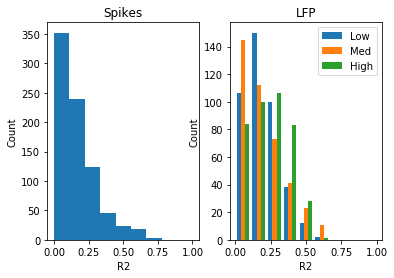

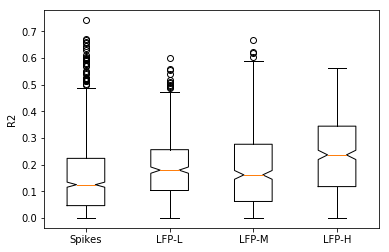

In [13]:
plt.figure()

# Histogram for spikes
plt.subplot(1,2,1)
plt.hist(mfullSpike['r2'].dropna(), bins = np.linspace(0.0, 1.0, 10))
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('Spikes')

# Histogram for LFS
plt.subplot(1,2,2)
plt.hist([mfullLFPLow['r2'].dropna(), mfullLFPMed['r2'].dropna(), mfullLFPHigh['r2'].dropna()],
         bins = np.linspace(0.0, 1.0, 10),  histtype = 'bar', stacked = False)
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('LFP')
plt.legend(['Low', 'Med', 'High'])

# Boxplot
plt.figure()
plt.boxplot([mfullSpike['r2'].dropna(), mfullLFPLow['r2'].dropna(), mfullLFPMed['r2'].dropna(), mfullLFPHigh['r2'].dropna()], 1)
plt.ylabel('R2')
plt.xticks([1,2,3,4], ['Spikes', 'LFP-L', 'LFP-M', 'LFP-H'])
plt.savefig('%s/r2boxplot.eps' % figdir, format='eps')

512 Significant Single Units


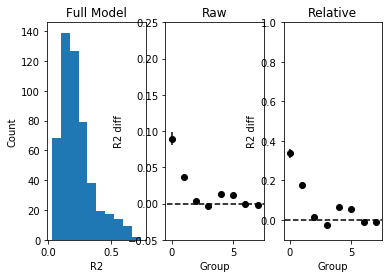

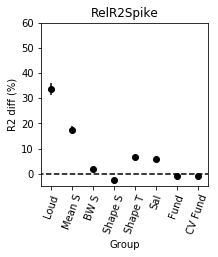

In [14]:
# Make Plots of Partial R2

# First for spikes
mfullSpikeSig = mfullSpike.loc[(mfullSpike['r2'] >= 2.0*mfullSpike['r2_std'])]
# Find the number of units
n_units = len(mfullSpikeSig.index)
print('%d Significant Single Units' % n_units)

# allocate space
r2_full_all = np.full(n_units, np.nan)
r2_diff_all = np.full((n_units, n_features), np.nan)
r2_reldiff_all = np.full((n_units, n_features), np.nan)
                         
for i_n in range(n_units):
    r2_full_all[i_n] = mfullSpikeSig['r2'].iloc[i_n]
    bird = mfullSpikeSig['experiment'].iloc[i_n] 
    site = mfullSpikeSig['site'].iloc[i_n]   
    neural_feat = mfullSpikeSig['neural feat'].iloc[i_n] 
    for i_f in range(n_features):
        # Find the correct record
        mNestedSpike = resultsPD.loc[(resultsPD['name'] =='Nested') & 
                                     (resultsPD['decomp'] == 'spike_rate') &
                                     (resultsPD['group'] == i_f) &
                                     (resultsPD['experiment'] == bird) &
                                     (resultsPD['site'] == site) &
                                     (resultsPD['neural feat'] == neural_feat)] 
        if len(mNestedSpike.index) != 1:
            print('Error: too many or two few entries')
        else:
            r2_diff_all[i_n, i_f] = r2_full_all[i_n] - mNestedSpike['r2'].iloc[0]
            r2_reldiff_all[i_n, i_f] = r2_diff_all[i_n, i_f]/r2_full_all[i_n]


plt.figure()
plt.subplot(1,3,1)
plt.hist(r2_full_all[np.logical_not(np.isnan(r2_full_all))])
plt.xlabel('R2')
plt.ylabel('Count')
plt.title('Full Model')
    
plt.subplot(1,3,2)
plt.errorbar(range(len(feature_groups)), np.nanmean(r2_diff_all, axis=0), yerr = 2.0*(np.nanstd(r2_diff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
plt.axis([-0.5, 7.5, -0.05, 0.25]) 
plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
plt.xlabel('Group')
plt.ylabel('R2 diff')
plt.title('Raw')
    
plt.subplot(1,3,3)
plt.errorbar(range(len(feature_groups)), np.nanmean(r2_reldiff_all, axis=0), yerr = 2.0*(np.nanstd(r2_reldiff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
plt.axis([-0.5, 7.5, -0.1, 1.0]) 
plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
plt.xlabel('Group')
plt.ylabel('R2 diff')
plt.title('Relative')
plt.show()

# This is the figure to save
titleStr = 'RelR2Spike'
plt.figure(facecolor='white', figsize=(3,3))
plt.errorbar(range(len(feature_groups)), 100.0*np.nanmean(r2_reldiff_all, axis=0), yerr = 200.0*(np.nanstd(r2_reldiff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
plt.axis([-0.5, 7.5, -5, 60]) 
plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
plt.xlabel('Group')
plt.ylabel('R2 diff (%)')
plt.xticks(range(8), feature_groups, rotation=70)
plt.title(titleStr)

plt.savefig('%s/%s.eps' % (figdir,titleStr), format='eps')



323 Significant electrodes for Low LFP
291 Significant electrodes for Med LFP
333 Significant electrodes for High LFP


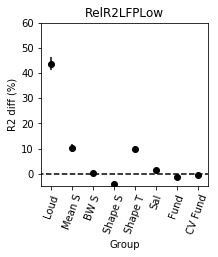

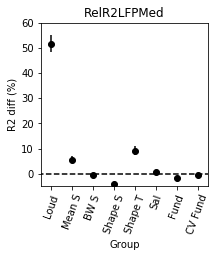

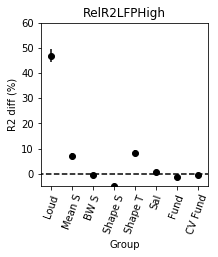

In [15]:
# Now for LFP
modelsLFP = [mfullLFPLow, mfullLFPMed, mfullLFPHigh]
namesLFP = ['Low', 'Med', 'High']

for i_m, modelLFP in enumerate(modelsLFP):
    mLFPSig = modelLFP.loc[(modelLFP['r2'] >= 2.0*modelLFP['r2_std'])]

    # Find the number of units
    n_units = len(mLFPSig.index)
    print('%d Significant electrodes for %s LFP' % (n_units, namesLFP[i_m]) )

    # Allocate space
    r2_full_all = np.full(n_units, np.nan)
    r2_diff_all = np.full((n_units, n_features), np.nan)
    r2_reldiff_all = np.full((n_units, n_features), np.nan)
                         
    for i_n in range(n_units):
        r2_full_all[i_n] = mLFPSig['r2'].iloc[i_n]
        bird = mLFPSig['experiment'].iloc[i_n] 
        site = mLFPSig['site'].iloc[i_n]   
        neural_feat = mLFPSig['neural feat'].iloc[i_n] 
        for i_f in range(n_features):
        # Find the correct record
            mNestedLFP = resultsPD.loc[(resultsPD['name'] =='Nested') & 
                                     (resultsPD['decomp'] == 'full_psds') &
                                     (resultsPD['group'] == i_f) &
                                     (resultsPD['experiment'] == bird) &
                                     (resultsPD['site'] == site) &
                                     (resultsPD['neural feat'] == neural_feat)] 
            if len(mNestedLFP.index) != 1:
                print('Error: too many or two few entries')
            else:
                r2_diff_all[i_n, i_f] = r2_full_all[i_n] - mNestedLFP['r2'].iloc[0]
                r2_reldiff_all[i_n, i_f] = r2_diff_all[i_n, i_f]/r2_full_all[i_n]


    # This is the figure to save
    titleStr = 'RelR2LFP%s' % namesLFP[i_m]
    plt.figure(facecolor='white', figsize=(3,3))
    plt.errorbar(range(len(feature_groups)), 100.0*np.nanmean(r2_reldiff_all, axis=0), yerr = 200.0*(np.nanstd(r2_reldiff_all, axis=0, ddof=1))/np.sqrt(n_units) , fmt='ko')
    plt.axis([-0.5, 7.5, -5, 60]) 
    plt.hlines(0, -1, 8, colors='k', linestyles='dashed')
    plt.xlabel('Group')
    plt.ylabel('R2 diff (%)')
    plt.xticks(range(8), feature_groups, rotation=70)
    plt.title(titleStr)

    plt.savefig('%s/%s.eps' % (figdir,titleStr), format='eps')
    

In [16]:
# Make Tuning Curves for loudness.
ia = 1    # This is the group corresponding to the Baseline model for meanSpect

# Get the spike data base for the base model
mBaseSpike = resultsPD.loc[(resultsPD['name'] =='Baseline') & 
                           (resultsPD['decomp'] == 'spike_rate') & 
                           (resultsPD['group'] == ia)] 

mBaseSpike.sort_values('r2', ascending = False, inplace = True)

/Users/frederictheunissen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Plot the top first 5 tuning curves for Loudness


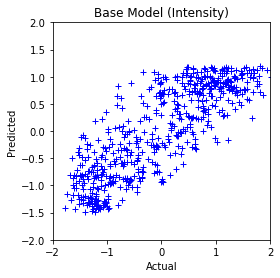

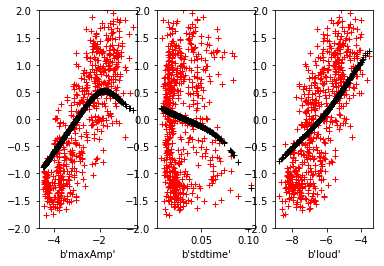

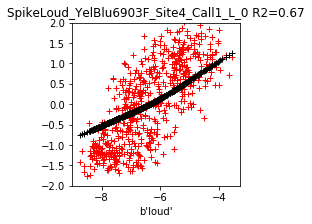

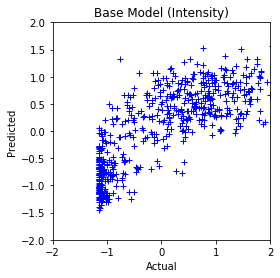

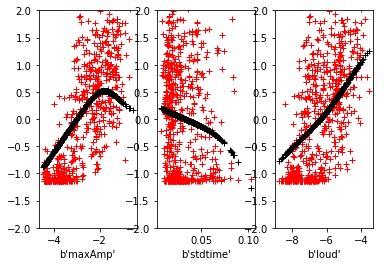

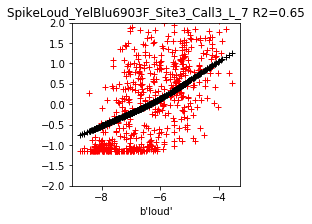

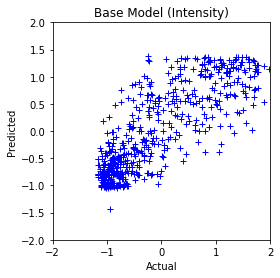

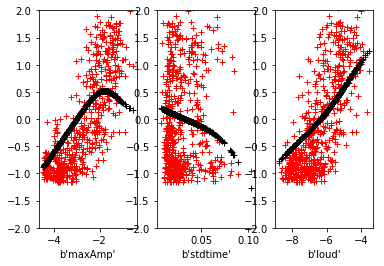

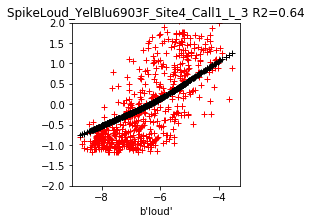

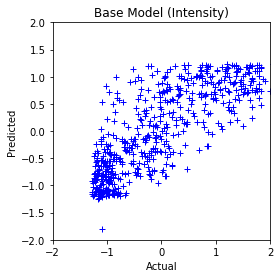

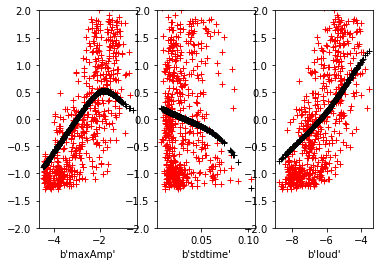

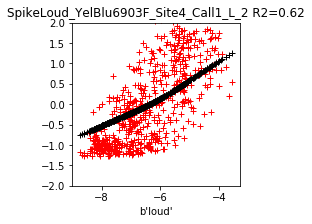

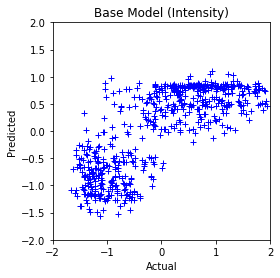

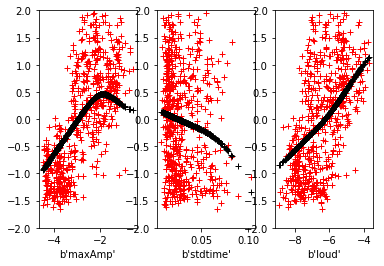

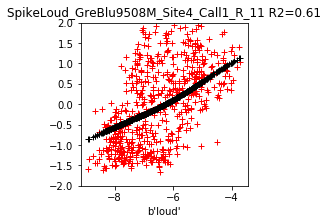

In [32]:
nplots = 5

for ipl in range(nplots):
    
    # Get info on record (for ease of code reading)
    exp_name = mBaseSpike.iloc[ipl].experiment    # Bird
    site = mBaseSpike.iloc[ipl].site              # Site
    decomp = mBaseSpike.iloc[ipl].decomp          # Neural Representation
    k = mBaseSpike.iloc[ipl]['neural feat']       # Electrode or Cell number
    
    # Setup directory for input files
    preproc_dir = '/Users/frederictheunissen/Documents/Data/mschachter/%s/preprocess' % exp_name
    preproc_file = os.path.join(preproc_dir, 'preproc_%s_%s.h5' % (site, decomp))
       
    # Read the data
    aed = AcousticEncoderDecoder()
    aed.read_preproc_file(preproc_file)
    aed.model_type = 'linear'    # I don't think this is used for anything 
    
    # Get the data parameters and shape/group stimulus as in run_encoder
    nsamps, nfeatures_stim = aed.S.shape
    nfeatures_neural = aed.X.shape[1]
    features, feature_groups = select_sound_feat(aed) 
    Sfull = np.hstack(features)
    Sfull_names = [name for feature_grp_names in feature_groups for name in feature_grp_names ] 

    Sadded_names =  base_feature_names[ia] + added_valuegroups[ia]
    ind_added = [Sfull_names.index(strval) for strval in Sadded_names]
    Sadded = Sfull[:,ind_added]
    base_features = [Sadded_names.index(strval) for strval in base_feature_names[ia] ]

    # Get baseline features in spline coordinates for plotting
    sr = StagewiseSplineRidgeRegression()
    Sb = sr.spline_basis(Sadded[:,base_features])
    nb_features = Sb.shape[1]
    
    y = deepcopy(aed.X[:, k])
    if zscore_response:
        y -= y.mean()
        y /= y.std(ddof=1)
        y[np.isnan(y)] = 0.
        y[np.isinf(y)] = 0.
                        
    plt.figure()
    plt.plot(y, mBaseSpike['predict'].iloc[ipl], 'b+')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')        
    plt.axis('square')
    plt.axis([-2, 2, -2, 2])
            
    plt.title('Base Model (Intensity)')
    plt.show()
                    
    plt.figure()
    for ip in base_features:
        plt.subplot(1,len(base_features), ip+1)
                
        plt.plot(Sadded[:,ip], y, 'r+')
                
        # Plot the prediction
        si = ip*6;
        ei = si + 6
                
        # The stimulus keeping other features constant
        St = deepcopy(Sb)
                
        for i in range(si):
            mean_col = np.mean(St[:,i])
            St[:,i] = mean_col
                    
        for i in range(ei,nb_features):
            mean_col = np.mean(St[:,i])
            St[:,i] = mean_col
    
        # get the encoder weights for this acoustic feature
        wj = mBaseSpike['W'].iloc[0]
    
        # get the prediction of the neural response based on the regression
        yhat = np.dot(St, wj) + mBaseSpike['b'].iloc[0]
        plt.plot(Sadded[:,ip], yhat, 'k+')
        limits = plt.axis()
        plt.axis([limits[0], limits[1], -2, 2])
        plt.xlabel(Sadded_names[ip])
        
        # Generate plots for paper with loudness
        if ip == 2:
            plt.figure(facecolor='white', figsize=(3,3))
            plt.plot(Sadded[:,ip], y, 'r+')
            plt.plot(Sadded[:,ip], yhat, 'k+')
            limits = plt.axis()
            plt.axis([limits[0], limits[1], -2, 2])
            plt.xlabel(Sadded_names[ip])
            titleStr = 'SpikeLoud_%s_%s_%d' % (exp_name, site, k)
            plt.title('%s R2=%.2f' % (titleStr, mBaseSpike.iloc[ipl]['r2']))
            plt.savefig('%s/%s.eps' % (figdir,titleStr), format='eps')
            
                



In [33]:
# Make Tuning Curves for loudness.
ia = 1    # This is the group corresponding to the Baseline model for meanSpect

# Get the spike data base for the base model
mMeanSSpike = resultsPD.loc[(resultsPD['name'] =='Added') & 
                           (resultsPD['decomp'] == 'spike_rate') & 
                           (resultsPD['group'] == ia)] 

mMeanSSpike.sort_values('r2', ascending = False, inplace = True)

/Users/frederictheunissen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


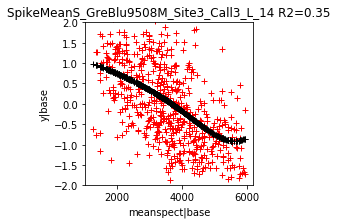

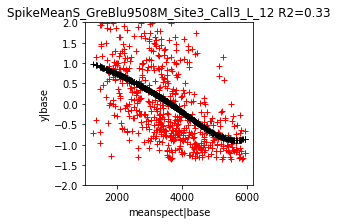

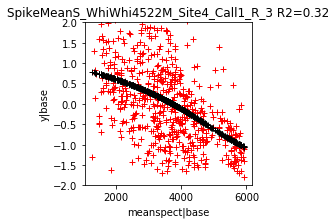

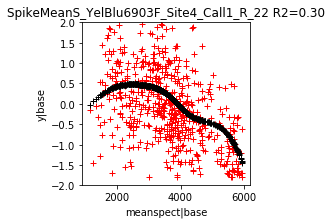

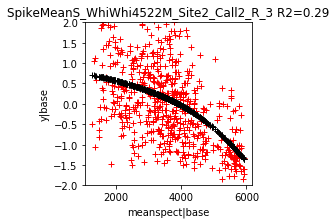

In [42]:
nplots = 5

for ipl in range(nplots):
    
    # Get info on record (for ease of code reading)
    exp_name = mMeanSSpike.iloc[ipl].experiment    # Bird
    site = mMeanSSpike.iloc[ipl].site              # Site
    decomp = mMeanSSpike.iloc[ipl].decomp          # Neural Representation
    k = mMeanSSpike.iloc[ipl]['neural feat']       # Electrode or Cell number
    
    # Find the corresponding base model
    mbase = resultsPD.loc[(resultsPD['name'] =='Baseline') & 
                           (resultsPD['decomp'] == 'spike_rate') & 
                           (resultsPD['group'] == ia) &
                           (resultsPD['experiment'] == exp_name) &
                           (resultsPD['site'] == site) &
                           (resultsPD['neural feat'] == k)] 
    
    
    # Setup directory for input files
    preproc_dir = '/Users/frederictheunissen/Documents/Data/mschachter/%s/preprocess' % exp_name
    preproc_file = os.path.join(preproc_dir, 'preproc_%s_%s.h5' % (site, decomp))
       
    # Read the data
    aed = AcousticEncoderDecoder()
    aed.read_preproc_file(preproc_file)
    aed.model_type = 'linear'    # I don't think this is used for anything 
    
    # Get the data parameters and shape/group stimulus as in run_encoder
    nsamps, nfeatures_stim = aed.S.shape
    nfeatures_neural = aed.X.shape[1]
    features, feature_groups = select_sound_feat(aed) 
    Sfull = np.hstack(features)
    Sfull_names = [name for feature_grp_names in feature_groups for name in feature_grp_names ] 

    Sadded_names =  base_feature_names[ia] + added_valuegroups[ia]
    ind_added = [Sfull_names.index(strval) for strval in Sadded_names]
    Sadded = Sfull[:,ind_added]
    base_features = [Sadded_names.index(strval) for strval in base_feature_names[ia] ]

    # Get baseline features in spline coordinates for plotting
    sr = StagewiseSplineRidgeRegression()
    Sb = sr.spline_basis(Sadded[:,base_features])
    nb_features = Sb.shape[1]
    
    y = deepcopy(aed.X[:, k])
    if zscore_response:
        y -= y.mean()
        y /= y.std(ddof=1)
        y[np.isnan(y)] = 0.
        y[np.isinf(y)] = 0.
        
    added_feature = Sadded_names.index(added_valuegroups[ia][0]) 
            
    if len(mbase) != 1:
        yres = y
    else:
        if mbase['r2'].iloc[0] > 2.0*mbase['r2_std'].iloc[0]:
            yres = y - mbase['predict'].iloc[0]
        else:
            yres = y
            
    plt.figure(facecolor='white', figsize=(3,3))
    plt.plot(Sadded[:,added_feature], yres, 'r+')
    plt.plot(Sadded[:,added_feature], mMeanSSpike.iloc[ipl]['predict'], 'k+')
    limits = plt.axis()
    plt.axis([limits[0], limits[1], -2, 2])
    plt.xlabel('%s|base' % Sadded_names[added_feature].decode('UTF-8'))
    plt.ylabel('y|base')
    titleStr = 'SpikeMeanS_%s_%s_%d' % (exp_name, site, k)
    plt.title('%s R2=%.2f' % (titleStr, mMeanSSpike.iloc[ipl]['r2']))
    plt.savefig('%s/%s.eps' % (figdir,titleStr), format='eps')



In [44]:
# Make Tuning Curves for loudness.
ia = 3    # Added value model for Saliency

# Get the spike data base for the base model
mSalSpike = resultsPD.loc[(resultsPD['name'] =='Added') & 
                           (resultsPD['decomp'] == 'spike_rate') & 
                           (resultsPD['group'] == ia)] 

mSalSpike.sort_values('r2', ascending = False, inplace = True)

/Users/frederictheunissen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


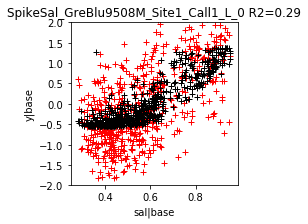

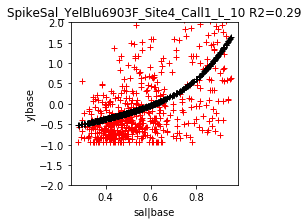

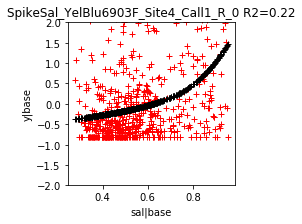

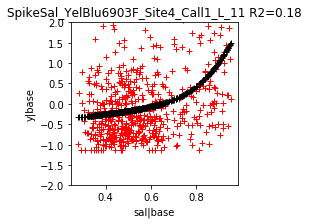

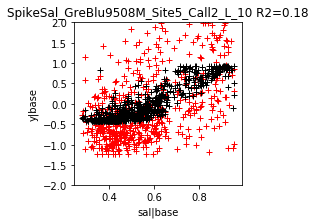

In [48]:
nplots = 5

for ipl in range(nplots):
    
    # Get info on record (for ease of code reading)
    exp_name = mSalSpike.iloc[ipl].experiment    # Bird
    site = mSalSpike.iloc[ipl].site              # Site
    decomp = mSalSpike.iloc[ipl].decomp          # Neural Representation
    k = mSalSpike.iloc[ipl]['neural feat']       # Electrode or Cell number
    
    # Find the corresponding base model
    mbase = resultsPD.loc[(resultsPD['name'] =='Baseline') & 
                           (resultsPD['decomp'] == 'spike_rate') & 
                           (resultsPD['group'] == ia) &
                           (resultsPD['experiment'] == exp_name) &
                           (resultsPD['site'] == site) &
                           (resultsPD['neural feat'] == k)] 
    
    
    # Setup directory for input files
    preproc_dir = '/Users/frederictheunissen/Documents/Data/mschachter/%s/preprocess' % exp_name
    preproc_file = os.path.join(preproc_dir, 'preproc_%s_%s.h5' % (site, decomp))
       
    # Read the data
    aed = AcousticEncoderDecoder()
    aed.read_preproc_file(preproc_file)
    aed.model_type = 'linear'    # I don't think this is used for anything 
    
    # Get the data parameters and shape/group stimulus as in run_encoder
    nsamps, nfeatures_stim = aed.S.shape
    nfeatures_neural = aed.X.shape[1]
    features, feature_groups = select_sound_feat(aed) 
    Sfull = np.hstack(features)
    Sfull_names = [name for feature_grp_names in feature_groups for name in feature_grp_names ] 

    Sadded_names =  base_feature_names[ia] + added_valuegroups[ia]
    ind_added = [Sfull_names.index(strval) for strval in Sadded_names]
    Sadded = Sfull[:,ind_added]
    base_features = [Sadded_names.index(strval) for strval in base_feature_names[ia] ]

    # Get baseline features in spline coordinates for plotting
    sr = StagewiseSplineRidgeRegression()
    Sb = sr.spline_basis(Sadded[:,base_features])
    nb_features = Sb.shape[1]
    
    y = deepcopy(aed.X[:, k])
    if zscore_response:
        y -= y.mean()
        y /= y.std(ddof=1)
        y[np.isnan(y)] = 0.
        y[np.isinf(y)] = 0.
        
    added_feature = Sadded_names.index(added_valuegroups[ia][0]) 
            
    if len(mbase) != 1:
        yres = y
    else:
        if mbase['r2'].iloc[0] > 2.0*mbase['r2_std'].iloc[0]:
            yres = y - mbase['predict'].iloc[0]
        else:
            yres = y
            
    plt.figure(facecolor='white', figsize=(3,3))
    plt.plot(Sadded[:,added_feature], yres, 'r+')
    plt.plot(Sadded[:,added_feature], mSalSpike.iloc[ipl]['predict'], 'k+')
    limits = plt.axis()
    plt.axis([limits[0], limits[1], -2, 2])
    plt.xlabel('%s|base' % Sadded_names[added_feature].decode('UTF-8'))
    plt.ylabel('y|base')
    titleStr = 'SpikeSal_%s_%s_%d' % (exp_name, site, k)
    plt.title('%s R2=%.2f' % (titleStr, mSalSpike.iloc[ipl]['r2']))
    plt.savefig('%s/%s.eps' % (figdir,titleStr), format='eps')

